In [2]:
os.chdir('C:\\Users\\Vishaal\\Documents\\GitHub\\Hybrid-Transfer-Learning\\Data')

In [159]:
'''

Generic Module Imports 

'''
import time
import os
import copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [230]:
'''
    Pennylane is an open source quantum machine learning package by Xanadu. Pennylane also allows to use IBMs Qiskit as an
    installed plugin. We may or may not evntually use that.
    
    Citation: 
    Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan and Nathan Killoran. 
    PennyLane. arXiv, 2018. arXiv:1811.04968
'''
import pennylane as qml
from pennylane import numpy as np # Same as standard numpy, but also does automatic differentiation

In [231]:
'''
    PyTorch is an open-source machine learning library by Facebook. It is similar to Tensorflow by Google. It's pretty 
    cool to use this to build models and import pre-trained neural nets like ResNet18. 
    
    PyTorch uses torch tensors and not numpy arrays. We may have to convert as and when necesary. 

'''

import torch
import torch.nn as nn                    #This serves as a base class for neural networks (NNs)#
import torch.optim as optim              #Contains built-in optimizer functions - like Stochastic Gradient Descent(SGD) & Adam Optimizer'''
from torch.optim import lr_scheduler     #Helps modulate learning rate based on number of epochs
import torchvision                       #PyTorchs imgage datasets and other related stuff
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [232]:
'''

    Initialize Some Parameters - For now we will use an integrated Pennylane Device. This is sort of a simulator for 
    a quantum computer. I will later attempt to use a real Quantum Computer using IBMs Q Experience but no guarantees. 
    This should not technically affect our results. Because we only use 4 qubits, the quantum simulator should have no 
    issues accurately simulating the process in polyomial time. Problems will arise for ~>50 qubits.
    
'''
n_qubits = 4              # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4             # Number of samples for each training step. This is the number of features taken in from ResNet18.
num_epochs = 30            # Number of training epochs. Set to 1 to train quickly. We will later change this to 30
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
rng_seed = 0                # Seed for random number generator
start_time = time.time()    # Start of the computation timer


In [233]:
'''
    Initialize the quantum device. Two options for names are Default & Gaussian. Shots is the number of times the circuit 
    will be run. 1024 or 2^10 is generally a good number. Wires is the number of modes to intialise the qubits in. 
    Remember qubits have a probabilistic nature and can take up various states. 
'''
dev = qml.device(name = 'default.qubit', shots = 1024, wires = 4)

In [234]:
'''
    Cuda is a parallel computing architecture created by Nvidia. The following line of code is to check if you have a GPU 
    in your computer and use it. Else, the CPU will be used.
'''
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [235]:
'''
    Directory for image data. Note the dataset is relatively small with only 250 images. We cannot train a whole classical
    or quantum CNN using such small data. However, because we are using transfer learning this would suffice to do some
    additional training. 
'''
data_dir = "..\\Data\\hymenoptera_data\\hymenoptera_data"

'''
    Create a dictionary of transforms we need to do to the image data. For both the training and validation set.
    Note: the values for normalise are the mean and std of the images in ImageNet (256 X 256 X 3).  
'''
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [236]:
'''
    Establish the training and validation image datasets. This is the torchvision method of loading data.
'''
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}

In [237]:
'''
    244 training images and 153 validation images in two different classes ants and bees
'''
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

In [239]:
'''
    Initialize the data loader. We don't load the data yet.
'''
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [240]:
'''
    Define a function to plot the images as they get ready
'''
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    '''
        Invert the normalisation we did before
    '''
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [241]:
'''
    The Hadamard gate applies to a single qubit in state 0 or state 1. Once applied it results in superposition and
    gives a 50% for state 0 or state 1 to exist. Basically - gives qubits their quantum nature.
    https://en.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_(H)_gate
'''

def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
'''
    Rotates a single qubit by theta radians along the y-axis. w is a list of angles in radians you want to rotate each
    qubit by
    https://www.quantum-inspire.com/kbase/ry-gate/
    https://pennylane.readthedocs.io/en/stable/code/api/pennylane.RY.html
'''        
def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        
'''
    This is the controlled-not operator. The CNOT gate operates on two qubits at a time. For example, if the first qubit is
    in state 1, the second one is flipped two. In other words, the state of the second qubit depends on the state of the 
    first one. This is kinda what quantum entanglement is. Einstein called it spooky phenomenon and although we have 
    experimental proof, we yet don't have conclusive mathematical proof from first principles to prove this. 
'''
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])
'''
    Designing the Variational Quantum Circuit - There are three steps innvolved...
    1. Embedding - Qubits are initialised in superimposed state. They are then rotated across to input parameters.
    2. Variational Layers - A sequence of trainable rotation layers and constant entangling layers is applied.
    3. Measurement - For each qubit, the expectation of the angular momentum (Z) operator is measured. This has to be done
                     using a classical bit which can then be processed. *Most quantum phenomenon has to be measured using
                     a classical bit. This is similar to the Schrodinger's cat experiment where quanutum phenomenon is 
                     maintined till a measurement is made. 
'''
'''
    When applied to a quantum function, it turns it into a QNode instance. Because, interface is set as torch, the input and 
    output have to be torch tensors. Interface can also be set to TensorFlow.
''' 
@qml.qnode(dev, interface = 'torch')

def quantum_network(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    H_layer(n_qubits)
    '''
        Embedding
    '''
    RY_layer(q_input_features)
    '''
        Variational Layers
    '''
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])
    '''
        Measuring Expectation - PauliZ operator applies a phase flip. PauliX is bit flip.PauliY does both.
    '''
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [242]:
'''
    A dressed quantum circuit with classical pre-processing and post-processing layers
'''
class DressedQuantumNet(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_network(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [243]:
'''
    Creating a hybrid NN using ResNet18 and the dressed quantum circuit...
    
'''
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

In [244]:
'''
    We use cross entropy as the loss function
'''
criterion = nn.CrossEntropyLoss()

In [245]:
'''
    We use an Adam optimizer that updates the weights of our model at each step of the process. It is a derivation
    of Stohasti Gradient Descent (SGD) but differs in that it has a a per-parameter adaptive learning rate that depends
    on the average of the magnitiude of recent gradiets i.e. how fast it it changing. It can provide good results fast
    but is not always the best as SGD sometimes finds better solutions. 
'''
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [246]:
'''
    We schedule to reduce the learning rate by a factor of gamma_lr_scheduler every 10 epochs
'''
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=7, gamma=gamma_lr_scheduler)

In [247]:
'''
    Training function
'''
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    proba = []
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                scheduler.step()
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    #_ seems to have the probabilities. preds is the actual output 0/1
                    _, preds = torch.max(outputs, 1)
                    if phase == 'validation':
                        print(_)
                        proba.append(_)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return (model, proba)

In [248]:
'''
    Training our model
'''
model_hybrid, p = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)


Training started:
Phase: train Epoch: 1/30 Loss: 0.6405 Acc: 0.6557        
tensor([ 0.0869, -0.1019, -0.2760, -0.0045])
tensor([ 0.1003,  0.3121, -0.3977, -0.6170])ch time: 4.3116
tensor([ 0.2525, -0.2521,  0.2795, -0.5269])ch time: 4.1257
tensor([ 0.1165, -0.1067, -0.2896, -0.2099])ch time: 4.0332
tensor([ 3.0056e-01,  1.4087e-01,  3.1177e-01, -2.8171e-04])
tensor([ 0.0930,  0.1191, -0.3930, -0.1924])ch time: 4.2849
tensor([ 0.0020, -0.3533, -0.1042,  0.0337])ch time: 4.3374
tensor([-0.3986,  0.2332, -0.0361,  0.1096])ch time: 4.0902
tensor([-0.3274,  0.1925, -0.5684,  0.1164])ch time: 3.9280
tensor([-0.1418,  0.1091,  0.2438,  0.1188])ch time: 4.1607
tensor([ 0.1028,  0.2690, -0.0763, -0.4142])tch time: 4.0483
tensor([ 0.1437, -0.1619,  0.0556, -0.1798])tch time: 4.2235
tensor([ 0.0911, -0.0149, -0.1734, -0.5263])tch time: 4.1789
tensor([-0.0661, -0.0314, -0.0704, -0.6077])tch time: 4.4249
tensor([-0.0990,  0.0186,  0.0491, -0.4807])tch time: 4.2472
tensor([ 0.2098,  0.1005,  0.0056

tensor([ 0.4347,  0.5793, -0.0936,  0.1964])tch time: 1.5069
tensor([0.5787, 0.2430, 0.5655, 0.5260])9 Batch time: 1.4984
tensor([0.0010, 0.0705, 0.1978, 0.1948])9 Batch time: 1.4778
tensor([0.2836, 0.1610, 0.3183, 0.5770])9 Batch time: 1.6510
tensor([0.4349, 0.1427, 0.5843, 0.2272])9 Batch time: 2.4545
tensor([ 0.5323,  0.2205, -0.2471, -0.2822])tch time: 1.6158
tensor([0.5265, 0.2197, 0.5527, 0.5853])9 Batch time: 2.2166
tensor([0.5661, 0.1318, 0.4837, 0.2080])9 Batch time: 1.6361
tensor([0.2174, 0.0376, 0.2180, 0.5713])9 Batch time: 1.6531
tensor([0.3026, 0.1187, 0.2023, 0.1445])9 Batch time: 1.8291
tensor([0.2323, 0.1824, 0.5519, 0.2266])9 Batch time: 1.5872
tensor([ 0.1883, -0.3155, -0.4952,  0.0640])tch time: 1.4834
tensor([0.5612, 0.4684, 0.2318, 0.1718])9 Batch time: 1.5022
tensor([0.5830, 0.5767, 0.0728, 0.1155])9 Batch time: 1.5375
tensor([ 0.4311, -0.0484,  0.2189,  0.2275])tch time: 1.6632
tensor([0.0716, 0.0189, 0.0068, 0.2273])9 Batch time: 2.6668
tensor([0.3378, 0.5895, 

tensor([ 0.1919,  0.2980, -0.3609,  0.3338])tch time: 1.5336
tensor([0.6977, 0.3334, 0.6902, 0.1559])9 Batch time: 1.7422
tensor([ 0.2978,  0.6991, -0.0418,  0.6996])tch time: 1.5027
tensor([ 0.6989,  0.1303, -0.1079,  0.2481])tch time: 1.4630
tensor([ 0.0759,  0.2531, -0.2030,  0.4757])tch time: 1.5136
tensor([-0.2058,  0.3322,  0.3341,  0.3145])tch time: 1.5054
tensor([0.6958, 0.6995, 0.4909, 0.0694])9 Batch time: 1.5428
tensor([ 0.6479, -0.3434,  0.6980,  0.6750])tch time: 1.5113
tensor([ 0.2711, -0.0245,  0.3058,  0.2146])tch time: 1.4720
Phase: validation   Epoch: 7/30 Loss: 0.3260 Acc: 0.9408        
Phase: train Epoch: 8/30 Loss: 0.3997 Acc: 0.8648        
tensor([0.2166, 0.6965, 0.3001, 0.7025])
tensor([0.0379, 0.7003, 0.6777, 0.2940]) Batch time: 1.5211
tensor([0.7020, 0.3092, 0.3394, 0.3318]) Batch time: 1.5784
tensor([0.1606, 0.2573, 0.0146, 0.2808]) Batch time: 1.5326
tensor([0.6819, 0.6016, 0.3241, 0.6513]) Batch time: 1.5105
tensor([0.2676, 0.4874, 0.6231, 0.7025]) Batch 

tensor([ 0.1537,  0.2033, -0.0789,  0.3474])tch time: 1.5245
tensor([ 0.4247,  0.1025, -0.2019,  0.6436])tch time: 1.5789
tensor([ 0.2138,  0.7183, -0.0608,  0.5687])tch time: 1.5731
tensor([0.1167, 0.7165, 0.2496, 0.7059])9 Batch time: 1.5718
tensor([ 0.7093,  0.2632, -0.1334, -0.4048])tch time: 1.6001
tensor([0.7173, 0.3468, 0.3288, 0.3402])9 Batch time: 1.5295
tensor([0.6871, 0.6985, 0.7103, 0.3014])39 Batch time: 1.5317
tensor([0.1184, 0.3251, 0.0232, 0.2317])39 Batch time: 1.5430
tensor([-0.3454,  0.6791,  0.2938,  0.3400])atch time: 1.5728
tensor([ 0.7181,  0.3314,  0.7111, -0.0362])atch time: 1.5367
tensor([0.2894, 0.6170, 0.2677, 0.3483])39 Batch time: 1.5839
tensor([ 0.1542, -0.2320, -0.0893,  0.7159])atch time: 1.5286
tensor([0.3121, 0.7155, 0.2701, 0.5670])39 Batch time: 1.6231
tensor([0.6048, 0.7123, 0.7160, 0.7155])39 Batch time: 1.7341
tensor([0.3254, 0.6495, 0.7180, 0.7042])39 Batch time: 1.7803
tensor([0.7182, 0.7182, 0.6162, 0.3261])39 Batch time: 1.5969
tensor([-0.402

tensor([0.3043, 0.3621, 0.3206, 0.7277])39 Batch time: 1.7299
tensor([0.7221, 0.5373, 0.5055, 0.0924])39 Batch time: 1.8249
tensor([-0.2843,  0.3380,  0.6140,  0.3427])atch time: 1.8274
tensor([0.0379, 0.6944, 0.7000, 0.7108])39 Batch time: 1.7499
tensor([0.7284, 0.3616, 0.7246, 0.3529])39 Batch time: 1.7939
tensor([0.3627, 0.1899, 0.6790, 0.2943])39 Batch time: 1.7852
tensor([0.3272, 0.6401, 0.7289, 0.6854])39 Batch time: 1.7719
tensor([0.2820, 0.7049, 0.3545, 0.0479])39 Batch time: 1.7851
tensor([0.6858, 0.6870, 0.3486, 0.7263])39 Batch time: 1.8260
tensor([ 0.7271,  0.3457, -0.3375,  0.7121])atch time: 1.7614
tensor([0.1345, 0.7134, 0.7185, 0.7262])39 Batch time: 1.7984
tensor([0.3604, 0.1912, 0.3554, 0.7292])39 Batch time: 1.7659
tensor([ 0.3226,  0.3544,  0.7262, -0.2711])atch time: 1.7548
tensor([0.3041, 0.3318, 0.0483, 0.1795])39 Batch time: 1.8162
tensor([-0.1703,  0.5870,  0.5736,  0.5944])atch time: 1.9250
tensor([0.3548, 0.6559, 0.7205, 0.3638])39 Batch time: 1.7142
tensor([

tensor([-0.2057,  0.6580,  0.3535,  0.6962])atch time: 0.7696
tensor([0.3243, 0.7051, 0.3632, 0.3519])39 Batch time: 0.7721
tensor([0.1955, 0.6702, 0.2331, 0.7289])39 Batch time: 0.7701
tensor([0.6984, 0.2762, 0.7241, 0.1762])39 Batch time: 0.7670
tensor([0.0420, 0.3634, 0.7234, 0.5117])39 Batch time: 0.7783
tensor([ 0.3476,  0.5918, -0.0307, -0.3065])atch time: 0.7789
tensor([ 0.3443,  0.3467, -0.5212,  0.7302])atch time: 0.8661
tensor([ 0.4819,  0.0903, -0.2469,  0.7197])atch time: 0.8921
Phase: validation   Epoch: 17/30 Loss: 0.3434 Acc: 0.9013        
Phase: train Epoch: 18/30 Loss: 0.3836 Acc: 0.8648        
tensor([0.7308, 0.3541, 0.5110, 0.7296])
tensor([0.7310, 0.7303, 0.3536, 0.7310])9 Batch time: 0.6966
tensor([0.7311, 0.7272, 0.6792, 0.3152])9 Batch time: 0.7675
tensor([ 0.3654,  0.3278, -0.0900,  0.6205])tch time: 0.7695
tensor([0.2611, 0.3609, 0.7310, 0.0943])9 Batch time: 0.7780
tensor([ 0.7076,  0.2697, -0.2912,  0.3311])tch time: 0.8175
tensor([0.3592, 0.6409, 0.2664, 0

tensor([ 0.0678, -0.4121,  0.2895, -0.2216])tch time: 1.1527
tensor([0.7321, 0.3317, 0.7076, 0.7321])9 Batch time: 1.3927
tensor([ 0.2993,  0.7002, -0.3002,  0.7211])tch time: 1.0706
tensor([0.3665, 0.2386, 0.3627, 0.3646])9 Batch time: 1.2775
tensor([0.2794, 0.1289, 0.7313, 0.3491])9 Batch time: 1.3835
tensor([ 0.7305,  0.7227,  0.5898, -0.4890])tch time: 1.4120
tensor([-0.0459,  0.3079, -0.3584,  0.6669])tch time: 1.1759
tensor([0.7300, 0.7275, 0.3305, 0.6258])39 Batch time: 1.0890
tensor([0.7317, 0.3585, 0.7052, 0.3465])39 Batch time: 1.0980
tensor([ 0.7320,  0.3423,  0.5565, -0.0072])atch time: 1.1071
tensor([0.2187, 0.3574, 0.7292, 0.2915])39 Batch time: 1.2086
tensor([0.3347, 0.7245, 0.7087, 0.3487])39 Batch time: 1.1623
tensor([0.6166, 0.7289, 0.1657, 0.3773])39 Batch time: 1.2492
tensor([ 0.5195, -0.2771,  0.7299,  0.7302])atch time: 1.1969
tensor([0.1452, 0.6441, 0.6946, 0.6862])39 Batch time: 1.2074
tensor([0.7320, 0.1309, 0.7250, 0.0084])39 Batch time: 1.1765
tensor([0.6594,

tensor([0.2776, 0.3503, 0.2270, 0.3147])39 Batch time: 0.8483
tensor([ 0.6502,  0.7322, -0.1401,  0.3620])atch time: 0.8921
tensor([0.3354, 0.5942, 0.7322, 0.1931])39 Batch time: 0.8999
tensor([-0.0458,  0.5419, -0.3221,  0.6043])atch time: 0.8924
tensor([ 0.3536, -0.3119,  0.7214,  0.7322])atch time: 1.0969
tensor([0.7271, 0.3591, 0.6115, 0.2468])39 Batch time: 0.8958
tensor([-0.1317,  0.7317,  0.3492,  0.3013])atch time: 0.8877
tensor([0.3144, 0.7322, 0.3316, 0.7146])39 Batch time: 0.8616
tensor([0.3366, 0.7317, 0.0751, 0.5817])39 Batch time: 0.9298
tensor([-0.1351,  0.7321,  0.1689,  0.7097])atch time: 0.8528
tensor([0.0950, 0.3242, 0.3290, 0.3629])39 Batch time: 0.8488
tensor([0.6849, 0.1434, 0.6139, 0.0972])39 Batch time: 0.8785
tensor([ 0.7261,  0.6674, -0.0045,  0.0534])atch time: 0.8757
tensor([0.3595, 0.6699, 0.1420, 0.7322])39 Batch time: 0.8625
tensor([0.7319, 0.1985, 0.6988, 0.3666])39 Batch time: 0.8695
tensor([ 0.0620,  0.3660, -0.2247,  0.7307])atch time: 0.9155
tensor([

tensor([-0.1600,  0.4992,  0.3353,  0.2935])atch time: 1.3428
tensor([0.6969, 0.3660, 0.7312, 0.7323])39 Batch time: 1.2796
tensor([0.7321, 0.2362, 0.7217, 0.7058])39 Batch time: 1.2062
tensor([0.7323, 0.3529, 0.6926, 0.7023])39 Batch time: 1.1474
tensor([ 0.6220, -0.4845,  0.4292,  0.7306])atch time: 1.1890
tensor([ 0.7285,  0.3505, -0.4043, -0.1218])atch time: 1.0821
tensor([0.3653, 0.2585, 0.3537, 0.6967])39 Batch time: 1.3043
tensor([0.0537, 0.7321, 0.6340, 0.2495])39 Batch time: 1.1283
tensor([ 0.1349, -0.0644,  0.7324,  0.7023])atch time: 1.1555
Phase: validation   Epoch: 27/30 Loss: 0.3288 Acc: 0.9276        
Phase: train Epoch: 28/30 Loss: 0.3645 Acc: 0.9098        
tensor([ 0.3633,  0.5738, -0.3165,  0.2530])
tensor([0.7080, 0.2818, 0.6980, 0.3664])9 Batch time: 1.0922
tensor([0.1341, 0.7190, 0.3297, 0.1846])9 Batch time: 1.1324
tensor([ 0.6402,  0.7283, -0.5032, -0.1683])tch time: 1.2961
tensor([0.3644, 0.6952, 0.3488, 0.3572])9 Batch time: 1.1834
tensor([0.3627, 0.3438, 0.17

In [282]:
model_hybrid.eval()
#real label
y = []
#scores. Calculate our pred using this
scores = []
for i, (inputs, labels) in enumerate(dataloaders['validation']):
    l.append(labels.tolist())
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_hybrid(inputs)
    _, preds = torch.max(outputs, 1)
    
    sm = torch.nn.Softmax()
    probabilities = sm(outputs) 
    
    for j in range(len(labels.tolist())):
        y.append(labels.tolist()[j])
        scores.append(probabilities.tolist()[j][1])

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [293]:
for i in range(len(scores)):
    if scores[i] >= 0.5:
        scores[i] = 1
    else:
        scores[i] = 0

Text(0.5, 0, 'False Positive Rate')

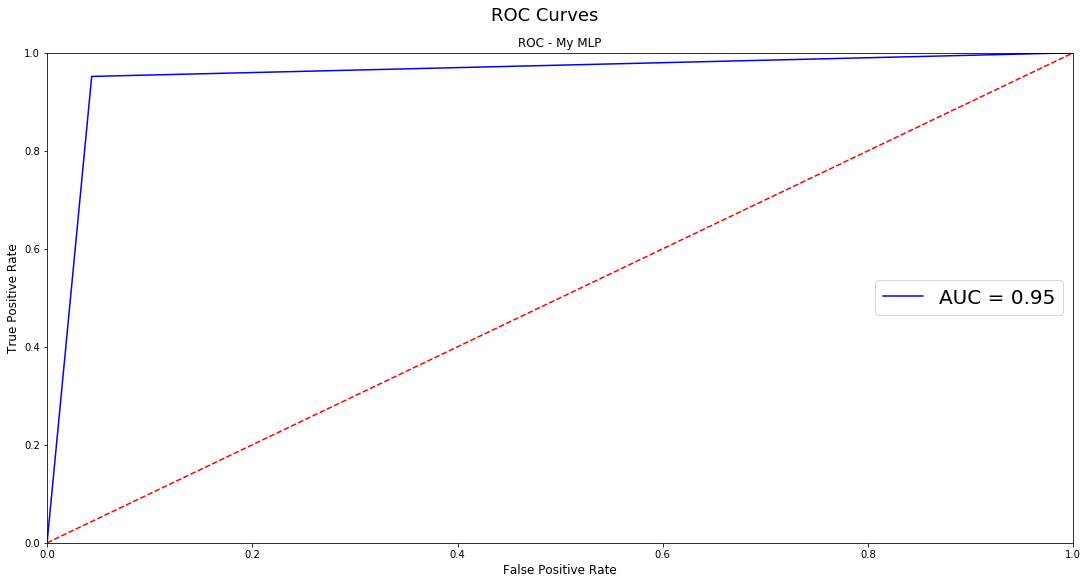

In [294]:
fig, axarr = plt.subplots(1,1, figsize=(15, 8),constrained_layout=True)
fig.suptitle("ROC Curves", fontsize=18)

fpr, tpr, threshold = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)

axarr.set_title('ROC - My MLP', fontsize=12)
axarr.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
axarr.legend(loc = 'right', fontsize=20)
axarr.plot([0, 1], [0, 1],'r--')
axarr.set_xlim([0, 1])
axarr.set_ylim([0, 1])
axarr.set_ylabel('True Positive Rate', fontsize=12)
axarr.set_xlabel('False Positive Rate', fontsize=12)
plt.savefig()